## Sanity checking when model behaviours should overlap

Many of the model classes in GPflow have overlapping behaviour in special cases. In this notebook, we fit some approximations to a model with a Gaussian likelihood, and make sure they're all the same. 

The models are:
 - `GPR`: Full Gaussian process regression.
 
 - `VGP`: A Gaussian approximation with Variational Bayes.
   Approximating a Gaussian posterior with a Gaussian should be exact.
   
 - `SVGP`: a sparse GP, with a Gaussian approximation. The inducing points are set to be at the data points, so again, should be exact. 
 
 - `SVGP` (with whitened representation): As above, but with a rotation applied to whiten the representation of the process.
 
 - `SGPR`: A sparse GP with a *collapsed* posterior (Titsias 2009). Again, the inducing points are fixed to the data points. 
 
 - `GPRFITC`: The FITC approximation. Again, the inducing points are fixed to the data points.
 
In all cases the parameters are estimated by the method of maximum likelihood (or approximate maximum likelihood, as appropriate). The parameter estimates should all be the same.

In [1]:
import gpflow
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

from gpflow.utilities import set_trainable
from gpflow.config import default_float
from gpflow.ci_utils import ci_niter

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)

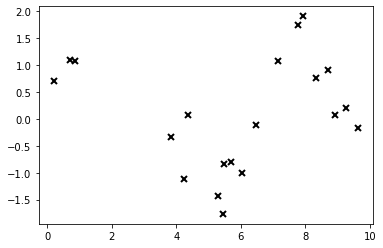

In [2]:
np.random.seed(0)
X = np.random.rand(20,1)*10
Y = np.sin(X) + 0.9 * np.cos(X*1.6) + np.random.randn(*X.shape)* 0.4
Xtest = np.random.rand(10,1)*10
plt.plot(X, Y, 'kx', mew=2);

In [3]:
data = (tf.convert_to_tensor(X, dtype=default_float()), tf.convert_to_tensor(Y, dtype=default_float()))
inducing_variable = tf.convert_to_tensor(X, dtype=default_float())

m1 = gpflow.models.GPR(data, kernel=gpflow.kernels.SquaredExponential())
m2 = gpflow.models.VGP(data, kernel=gpflow.kernels.SquaredExponential(), likelihood=gpflow.likelihoods.Gaussian())
m3 = gpflow.models.SVGP(gpflow.kernels.SquaredExponential(), gpflow.likelihoods.Gaussian(), inducing_variable, q_diag=False)
set_trainable(m3.inducing_variable, False)

m4 = gpflow.models.SVGP(gpflow.kernels.SquaredExponential(), gpflow.likelihoods.Gaussian(), inducing_variable, q_diag=False, whiten=True)
set_trainable(m4.inducing_variable, False)

m5 = gpflow.models.SGPR(data, kernel=gpflow.kernels.SquaredExponential(), inducing_variable=inducing_variable)
set_trainable(m5.inducing_variable, False)

m6 = gpflow.models.GPRFITC(data, kernel=gpflow.kernels.SquaredExponential(), inducing_variable=inducing_variable)
set_trainable(m6.inducing_variable, False)

models = [m1, m2, m3, m4, m5, m6]

Now, we optimize the models. For `GPR`, `SVGP`, and `GPRFITC`, this simply optimizes the hyperparameters (since the inducing points are fixed). For the variational models, this jointly maximises the lower bound to the marginal likelihood (Evidence Lower Bound, ELBO) with respect to the variational parameters and the kernel and likelihood hyperparameters.

In [4]:
for m in models:
    opt = gpflow.optimizers.Scipy()
    if isinstance(m, gpflow.models.SVGP):
        loss_fn = lambda: - m.log_marginal_likelihood(data)
    else:
        loss_fn = lambda: - m.log_marginal_likelihood()
        
    opt.minimize(loss_fn, variables=m.trainable_variables, options=dict(maxiter=ci_niter(1000)))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f66645d3ef0>, <gast.gast.Assign object at 0x7f66645d36d8>, <gast.gast.Return object at 0x7f66645d3b70>]


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f66645d3ef0>, <gast.gast.Assign object at 0x7f66645d36d8>, <gast.gast.Return object at 0x7f66645d3b70>]


If everything worked as planned, the models should have the same:

 - prediction functions
 - log (marginal) likelihood
 - kernel parameters
 
For the variational models, where we use a ELBO in place of the likelihood, the ELBO should be tight to the likelihood in the cases studied here. 

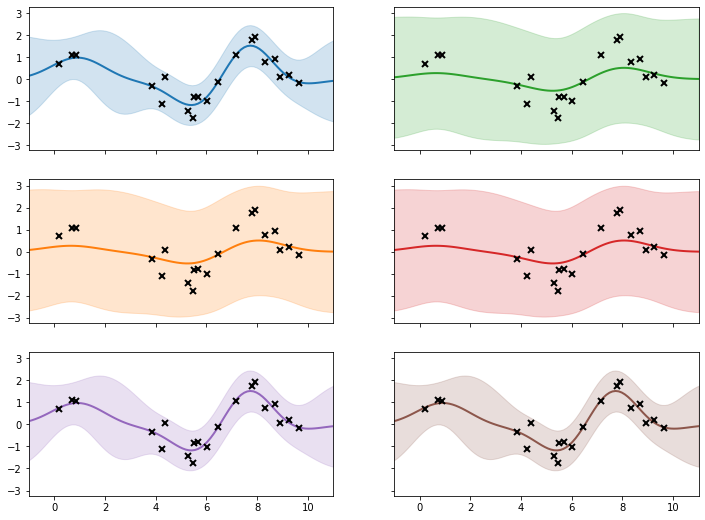

In [5]:
def plot(m, color, ax):
    xx = np.linspace(-1, 11, 100)[:,None]
    mu, var = m.predict_y(xx)
    ax.plot(xx, mu, color, lw=2)
    ax.fill_between(xx[:,0], mu[:,0] -  2*np.sqrt(var[:,0]), mu[:,0] +  2*np.sqrt(var[:,0]), color=color, alpha=0.2)
    ax.plot(X, Y, 'kx', mew=2)
    ax.set_xlim(-1, 11)

f, ax = plt.subplots(3,2,sharex=True, sharey=True, figsize=(12,9))
plot(m1, 'C0', ax[0,0])
plot(m2, 'C1', ax[1,0])
plot(m3, 'C2', ax[0,1])
plot(m4, 'C3', ax[1,1])
plot(m5, 'C4', ax[2,0])
plot(m6, 'C5', ax[2,1])

Here are the kernels and likelihoods, which show the fitted kernel parameters and noise variance:

In [6]:
for m in models:
    print(m.__class__.__name__)
    print(f"  kernel lengthscale  = {m.kernel.lengthscale.numpy():.5g}")
    print(f"  kernel variance     = {m.kernel.variance.numpy():.5}")
    print(f"  likelihood variance = {m.likelihood.variance.numpy():.5}")

GPR
  kernel lengthscale  = 1.072
  kernel variance     = 0.85495
  likelihood variance = 0.16625
VGP
  kernel lengthscale  = 1.0226
  kernel variance     = 0.67549
  likelihood variance = 1.2397
SVGP
  kernel lengthscale  = 1.0226
  kernel variance     = 0.67549
  likelihood variance = 1.2397
SVGP
  kernel lengthscale  = 1.0226
  kernel variance     = 0.67549
  likelihood variance = 1.2397
SGPR
  kernel lengthscale  = 1.072
  kernel variance     = 0.85495
  likelihood variance = 0.16626
GPRFITC
  kernel lengthscale  = 1.072
  kernel variance     = 0.85495
  likelihood variance = 0.16625


Here are the likelihoods (or ELBOs):

In [7]:
for m in models:
    if isinstance(m, gpflow.models.SVGP):
        print(f"{m.__class__.__name__:30}  {m.log_likelihood(data)}")
    else:
        print(f"{m.__class__.__name__:30}  {m.log_likelihood()}")

GPR                             -18.842093705269296
VGP                             -28.16758412796417
SVGP                            -28.167573458982126
SVGP                            -28.167573458982126
SGPR                            -18.842131953985643
GPRFITC                         -18.84208853228374
